## Model Evaluation and Hyper parameter tuning

In [1]:
import numpy as np
import pandas as pd

In [2]:
## Importing the Wisconsin breast cancer dataset
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# using sklearn's label encoder to convert target from string to integer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X = df.loc[:, 2:].values
y = le.fit_transform(df.iloc[:, 1])
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
le.transform(['M', 'B'])

array([1, 0])

In [5]:
# splitting the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.2,
                                                   random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [6]:
## Combining the transforms and models into a pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2),
                       LogisticRegression(random_state=1, solver='lbfgs'))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f"Test Accuracy: {pipe_lr.score(X_test, y_test):.3f}")

Test Accuracy: 0.956


In [7]:
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

In [8]:
y_pred

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1])

In [9]:
## Using stratified kfold validation method that ensures balanced dataset
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f"Fold: {k + 1}, Class dist.: {np.bincount(y_train[train])} Acc: {score}")

print(f"CV accuracy {np.mean(score):.3f} +/- {np.std(scores)}")

Fold: 1, Class dist.: [256 153] Acc: 0.9347826086956522
Fold: 2, Class dist.: [256 153] Acc: 0.9347826086956522
Fold: 3, Class dist.: [256 153] Acc: 0.9565217391304348
Fold: 4, Class dist.: [256 153] Acc: 0.9565217391304348
Fold: 5, Class dist.: [256 153] Acc: 0.9347826086956522
Fold: 6, Class dist.: [257 153] Acc: 0.9555555555555556
Fold: 7, Class dist.: [257 153] Acc: 0.9777777777777777
Fold: 8, Class dist.: [257 153] Acc: 0.9333333333333333
Fold: 9, Class dist.: [257 153] Acc: 0.9555555555555556
Fold: 10, Class dist.: [257 153] Acc: 0.9555555555555556
CV accuracy 0.956 +/- 0.013854294239660376


In [10]:
### Using sklearn's method to do the above less verbosely
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train, y=y_train,
                        cv=10,
                        n_jobs=1)
print(f"CV accuracy scores: {scores}")
print(f"CV accuracy: {np.mean(scores):.3f} +/-{np.std(scores):.3f}")

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/-0.014


## Diagnosing bias and variance problems with learning curves

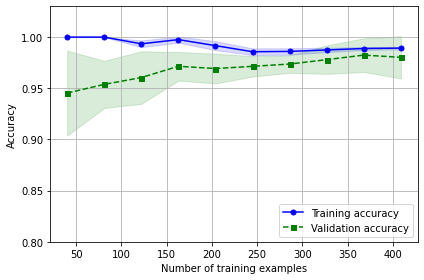

In [11]:
## Plotting the training and validation accuracies 

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty='l2', random_state=1,
                                         solver='lbfgs', max_iter=10000))

train_sizes, train_scores, test_scores = \
                        learning_curve(estimator=pipe_lr,
                                      X=X_train,
                                      y=y_train,
                                      train_sizes=np.linspace(.1, 1.0, 10),
                                      cv=10,
                                      n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o',
        markersize=5, label="Training accuracy")

plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation accuracy')

plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

In [12]:
train_sizes

array([ 40,  81, 122, 163, 204, 245, 286, 327, 368, 409])

## Validation curve

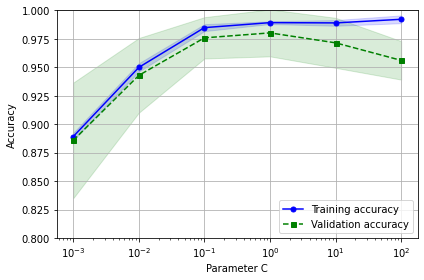

In [13]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                        estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        param_name='logisticregression__C',
                        param_range=param_range,
                        cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
        color='blue', marker='o',
        markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                train_mean - train_std, alpha=0.15,
                color='blue')

plt.plot(param_range, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation accuracy')

plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

## Grid Search method to exhaustively try hyper parameters

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 refit=True,
                 cv=10,
                 n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [15]:
clf = gs.best_estimator_
## No need to refit the model because it is already refit with the callback above
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

Test accuracy: 0.974


## Nested Cross Validation

In [16]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=2)

scores = cross_val_score(gs, X_train, y_train,
                        scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} +/-{np.std(scores):.3f}')

CV accuracy: 0.974 +/-0.015


In [17]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train,
                        scoring='accuracy', cv=5)
print(f"CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

CV accuracy: 0.934 +/- 0.016


## Different performance evaluation metrics

In [63]:
## Using sklearn and matplotlib for confusion matrix
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


In [83]:
## Function that creates the confusion matrix. 
def confusion_matrix(true, pred):
    K = len(np.unique(true))
    result = np.zeros((K, K))
    
    for i in range(len(true)):
        result[true[i]][pred[i]] += 1
    return result
confusion_matrix(y_test, y_pred)

array([[71.,  1.],
       [ 2., 40.]])

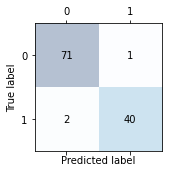

In [75]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

### Optimizing precision and recall calssification model
- Error is the sum of all flase predictions divided by total number of predictions
- Accuracy is the sum of all the true predictions divided by the total number of predictions

In [87]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'Precision: {precision_score(y_true=y_test, y_pred=y_pred)}')
print(f"Recall: {recall_score(y_true=y_test, y_pred=y_pred)}")
print(f"F1: {f1_score(y_true=y_test, y_pred=y_pred)}")

Precision: 0.975609756097561
Recall: 0.9523809523809523
F1: 0.963855421686747


In [89]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### Plotting the Receiver Operating Characteristic (ROC)

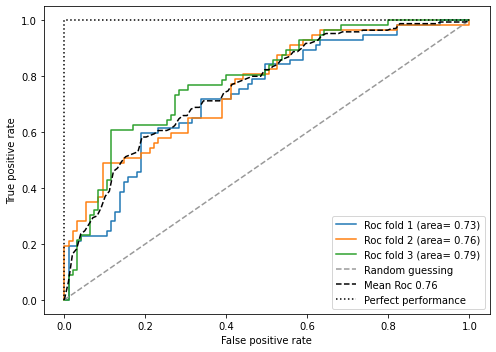

In [107]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version

if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp
    
pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2',
                                         random_state=1,
                                         solver='lbfgs',
                                         C=100.0))

X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                        y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                    probas[:, 1],
                                    pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
            tpr,
            label=f'Roc fold {(i + 1)} (area= {roc_auc:.2f})')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
        color=(0.6, 0.6, 0.6),
        label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f"Mean Roc {(mean_auc):.2f}")
#         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
        [0, 1, 1],
        linestyle=':',
        color='black',
        label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

### The scoring metrics for multiclass classification 

In [108]:
pre_scorer = make_scorer(score_func=precision_score,
                        pos_label=1,
                        greater_is_better=True,
                        average='micro')
pre_scorer

make_scorer(precision_score, pos_label=1, average=micro)

### Class imbalances 

In [115]:
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

In [118]:
preds = np.zeros_like(y_imb)
np.mean(y_imb == preds) * 100

89.92443324937027

In [119]:
from sklearn.utils import resample

print("Numner of class 1 examples before:", X_imb[y_imb == 1].shape[0])
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                   y_imb[y_imb == 1],
                                   replace=True,
                                   n_samples=X_imb[y_imb == 0].shape[0],
                                   random_state=123)
print("Number of class 1 examples after:", X_upsampled.shape[0])

Numner of class 1 examples before: 40
Number of class 1 examples after: 357


In [120]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [121]:
y_pred = np.zeros_like(y_bal)
np.mean(y_bal == y_pred) * 100

50.0

(397, 30)